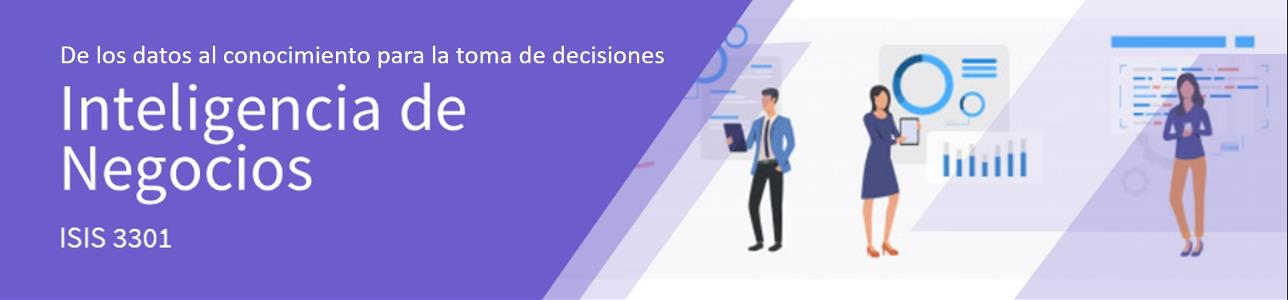

# 0. Configuración de entorno

In [112]:
%pip install pandas scikit-learn nltk matplotlib seaborn openpyxl nltk -q
#!python -m spacy download es_core_news_lg -q


Note: you may need to restart the kernel to use updated packages.


In [146]:

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Preprocesamiento y features
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelado y algoritmos
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model selection
from sklearn.model_selection import (
    train_test_split, GridSearchCV
)

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix

import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

from sklearn.base import clone



dict_ods = {
    1: "Fin de la pobreza",
    3: "Salud y bienestar",
    4: "Educación de calidad",
}


In [114]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1. Documentación del aprendizaje automático
[Canvas](../docs/canvas.docx)

# 2. Entendimiento y preparación de datos
## 2.1 Carga de datos

In [115]:
df_test = pd.read_excel('../data/Datos de prueba_proyecto.xlsx')
df = pd.read_excel('../data/Datos_proyecto.xlsx')

In [116]:
x,y = df.shape
print(f'El dataset tiene {x} filas (opiniones)')

El dataset tiene 2424 filas (opiniones)


## 2.2 Distribución de datos

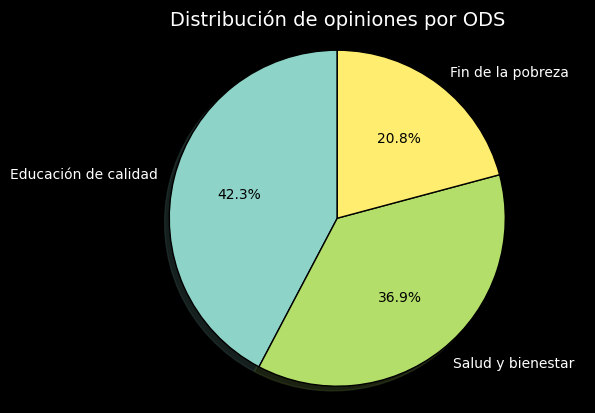

In [117]:
label_counts = df['labels'].value_counts()
label_counts.index = label_counts.index.map(dict_ods)

plt.figure(facecolor='black')  
ax = label_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    cmap='Set3',
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    textprops={'color': 'white'}
)

ax.set_facecolor('black')
plt.title("Distribución de opiniones por ODS", color='white', fontsize=14)
plt.ylabel("")
plt.axis("equal")

for text in ax.texts:
    if "%" in text.get_text():  
        text.set_color("black")

plt.show()


## 2.3 Valores nulos y repetidos

In [118]:
nulos = df.isnull().sum()

print("Valores nulos por columna:")
print(nulos)

Valores nulos por columna:
textos    0
labels    0
dtype: int64


In [119]:
print("Opiniones repetidas:", (df['textos'].value_counts()>1).sum())

Opiniones repetidas: 0


## 2.4 Longitud de opiniones

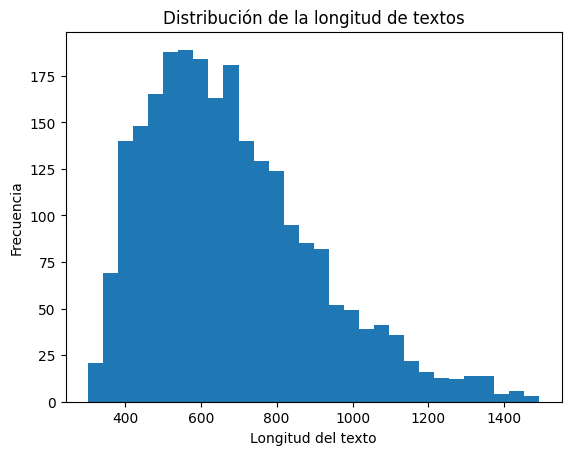

In [120]:
df["longitud"] = df["textos"].str.len()
plt.hist(df["longitud"], bins=30)
plt.xlabel("Longitud del texto")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de textos")
plt.show()

In [121]:
min_len = df["textos"].str.len().min()
print("Longitud mínima encontrada:", min_len)

texto_mas_corto = df.loc[df["textos"].str.len().idxmin(), "textos"]
print("Texto más corto:", texto_mas_corto)

Longitud mínima encontrada: 303
Texto más corto: En 2014, Bután fue testigo del mayor número de casos de drogas jamás registrado por las autoridades (644 casos). La gran mayoría (90%) estaban relacionados con la posesión de sustancias controladas. El cannabis, que además de cultivarse también crecía en estado salvaje, fue la droga de abuso más común.


La opinión más corta de los datos de prueba es de 303 caracteres. Según [help.imbd.com](https://help.imdb.com/article/contribution/contribution-information/user-review-guidelines/GABTWSNLDNFLPRRH?utm_source=chatgpt.com#) "La longitud mínima de las reseñas es de 300 caracteres para garantizar el mayor valor para nuestros usuarios". En este caso no hay opiniones con menos de 300 caracteres, pero en un futuro si puede que hallan, por lo que se filtran:

In [122]:
df_filtrado = df[df["textos"].str.len() >= 300]

## 2.5. Limpieza del Texto:


In [123]:
def limpiar_texto(texto):
    # 1. Minúsculas
    texto = texto.lower()
    
    # 2. Eliminar puntuación, números y caracteres especiales
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    
    # 3. Tokenización
    tokens = word_tokenize(texto, language="spanish")
    
    # 4. Eliminar stopwords
    stop_words = set(stopwords.words("spanish"))
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Normalización (ejemplo con stemming)
    stemmer = SnowballStemmer("spanish")
    tokens = [stemmer.stem(word) for word in tokens]
    
    # lematización:
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


In [124]:
t_wiki = "En 2014, Bután fue testigo del mayor número de casos de drogas jamás registrado por las autoridades (644 casos). La gran mayoría (90%) estaban relacionados con la posesión de sustancias controladas. El cannabis, que además de cultivarse también crecía en estado salvaje, fue la droga de abuso más común."
limpiar_texto(t_wiki)

'butan testig mayor numer ca drog jamas registr autor ca gran mayor relacion posesion sustanci control cannabis ademas cultiv crec salvaj drog abus comun'

In [125]:
df_filtrado["texto_limpio"] = df_filtrado["textos"].apply(limpiar_texto)
df_filtrado.head()

,textos,labels,longitud,texto_limpio
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,aprendizaj educ consider sinon escolariz forma...
1,Para los niños más pequeños (bebés y niños peq...,4,516,niñ pequeñ bebes niñ pequeñ capacit especializ...
2,"Además, la formación de especialistas en medic...",3,659,ademas formacion especial medicin general incl...
3,En los países de la OCDE se tiende a pasar de ...,4,693,pais ocde tiend pa cur obligatori optat abiert...
4,Este grupo se centró en las personas que padec...,3,608,grup centr person padec trastorn mental comorb...


Se eliminan columnas que ya no se usan:

In [126]:
df_filtrado.drop(columns=["longitud", "textos"], inplace=True)

Se dividen los datos con una proporción de 70% para entrenar y 30% para probar:

In [127]:
# Variables
X = df_filtrado["texto_limpio"]
y = df_filtrado["labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [128]:
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# 3. Modelado y evaluación

## 3.1 ...

## 3.2 Función para mostrar la matriz de confusión

In [129]:
def plot_confusion_matrix(y_true, y_pred, clases, titulo="Matriz de Confusión"):
    """
    Dibuja una matriz de confusión bonita con seaborn.
    
    Parámetros:
    - y_true: etiquetas reales
    - y_pred: etiquetas predichas
    - clases: lista con nombres de las clases (ej. ["Negativa", "Positiva"])
    - titulo: título del gráfico
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(titulo)
    plt.show()
    
def run_model_(model, param_grid, title):
    pipeline = Pipeline([
        ('clf', model)
    ])

    grid_search = GridSearchCV(
    pipeline,
    param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train_vec, y_train)

    print("Mejor modelo:", grid_search.best_estimator_)
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor f1_macro en CV:", grid_search.best_score_)

    y_pred = grid_search.predict(X_test_vec)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, clases=[dict_ods[i] for i in sorted(dict_ods.keys())], titulo=title)
    pass

def run_model(model, param_grid, title):
    pipeline = Pipeline([
        ('clf', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring='f1_macro'
    )

    grid_search.fit(X_train_vec, y_train)

    best_model = grid_search.best_estimator_
    print("="*60)
    print(" Mejor modelo:", best_model)
    print(" Mejores parámetros:", grid_search.best_params_)
    print(" Mejor f1_macro en CV:", grid_search.best_score_)
    print("="*60)

    y_pred = best_model.predict(X_test_vec)

    print("\n Evaluación en conjunto de test:")
    print(f"Accuracy:              {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (Macro):     {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Precision (Weighted):  {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (Macro):        {recall_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (Weighted):     {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 (Macro):            {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1 (Weighted):         {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\n Reporte por clase:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(
        y_test, y_pred,
        clases=[dict_ods[i] for i in sorted(dict_ods.keys())],
        titulo=title
    )

    return best_model

## 3.3 Modelos

### 3.3.1 Multinomial Naive Bayes

Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Mejor modelo: Pipeline(steps=[('clf', MultinomialNB(alpha=0.1))])
 Mejores parámetros: {'clf__alpha': 0.1}
 Mejor f1_macro en CV: 0.9607145992116098

 Evaluación en conjunto de test:
Accuracy:              0.9464
Precision (Macro):     0.9465
Precision (Weighted):  0.9466
Recall (Macro):        0.9362
Recall (Weighted):     0.9464
F1 (Macro):            0.9408
F1 (Weighted):         0.9461

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.94      0.89      0.92       152
           3       0.95      0.94      0.95       268
           4       0.94      0.98      0.96       308

    accuracy                           0.95       728
   macro avg       0.95      0.94      0.94       728
weighted avg       0.95      0.95      0.95       728



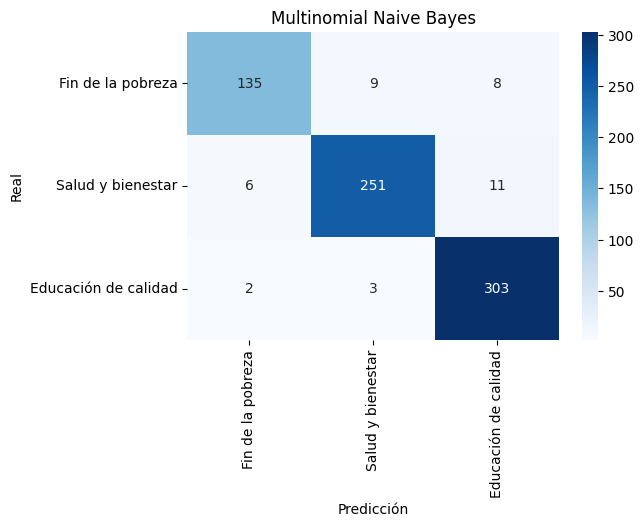

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,alpha,0.1
,force_alpha,True
,fit_prior,True
,class_prior,None


In [130]:
model = MultinomialNB()
param_grid = {
    "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
}
run_model(model, param_grid, "Multinomial Naive Bayes")

### 3.3.2 Logistic Regresion (Juan Hernández)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Mejor modelo: Pipeline(steps=[('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=42))])
 Mejores parámetros: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
 Mejor f1_macro en CV: 0.9807641888022254

 Evaluación en conjunto de test:
Accuracy:              0.9712
Precision (Macro):     0.9677
Precision (Weighted):  0.9711
Recall (Macro):        0.9652
Recall (Weighted):     0.9712
F1 (Macro):            0.9664
F1 (Weighted):         0.9711

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       152
           3       0.96      0.98      0.97       268
           4       0.99      0.98      0.99       308

    accuracy                           0.97       728
   macro avg       0.97      0.97      0.97       728
weighted avg       0.97      0.97      

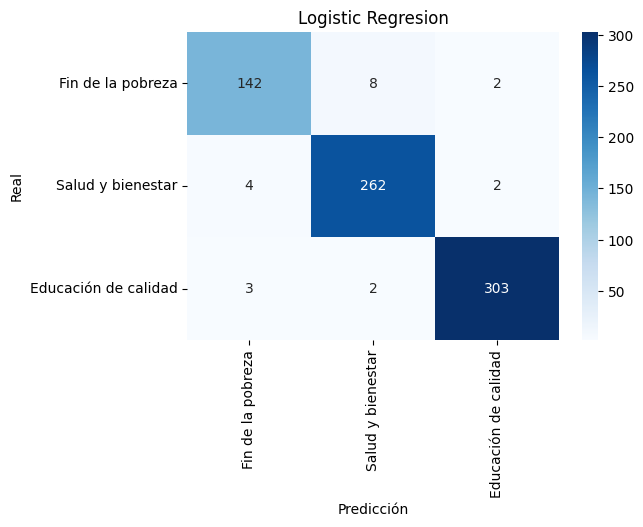

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'


In [131]:
model = LogisticRegression(max_iter=1000, random_state=42)
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "Logistic Regresion")

### 3.3.3 Desicion Tree

Fitting 5 folds for each of 48 candidates, totalling 240 fits
 Mejor modelo: Pipeline(steps=[('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                        random_state=42))])
 Mejores parámetros: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1}
 Mejor f1_macro en CV: 0.9207253261721874

 Evaluación en conjunto de test:
Accuracy:              0.9080
Precision (Macro):     0.8986
Precision (Weighted):  0.9079
Recall (Macro):        0.8973
Recall (Weighted):     0.9080
F1 (Macro):            0.8979
F1 (Weighted):         0.9079

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.85      0.84      0.85       152
           3       0.91      0.92      0.91       268
           4       0.93      0.93      0.93       308

    accuracy                           0.91       728
   macro avg       0.90      0.90      0.90       728
wei

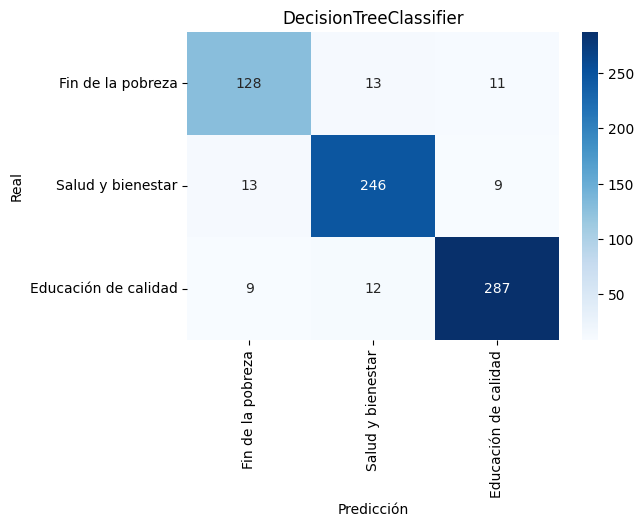

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,criterion,'entropy'
,splitter,'best'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None


In [132]:
model = DecisionTreeClassifier(random_state=42)
param_grid = {
    "clf__max_depth": [5, 10, 20, None],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__criterion": ["gini", "entropy"],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "DecisionTreeClassifier")

### 3.3.4 KNN (Jerónimo Pineda)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Mejor modelo: Pipeline(steps=[('clf',
                 KNeighborsClassifier(n_neighbors=10, weights='distance'))])
 Mejores parámetros: {'clf__n_neighbors': 10, 'clf__weights': 'distance'}
 Mejor f1_macro en CV: 0.9665825982817433

 Evaluación en conjunto de test:
Accuracy:              0.9437
Precision (Macro):     0.9376
Precision (Weighted):  0.9449
Recall (Macro):        0.9402
Recall (Weighted):     0.9437
F1 (Macro):            0.9384
F1 (Weighted):         0.9438

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.89      0.93      0.91       152
           3       0.98      0.93      0.95       268
           4       0.94      0.97      0.95       308

    accuracy                           0.94       728
   macro avg       0.94      0.94      0.94       728
weighted avg       0.94      0.94      0.94       728



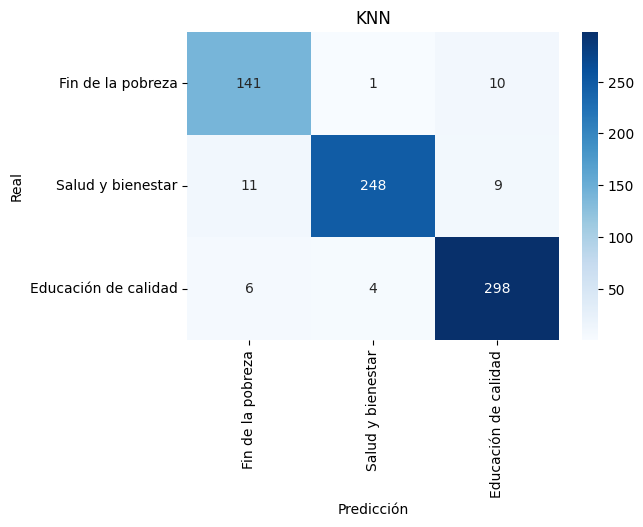

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_neighbors,10
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None


In [133]:
model = KNeighborsClassifier()
param_grid = {
    "clf__n_neighbors": [1,2,3,4,3, 5, 10, 15],
    "clf__weights": ["uniform", "distance"]
}
run_model(model, param_grid, "KNN")

### 3.3.5 Random Forest (David)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
 Mejor modelo: Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])
 Mejores parámetros: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
 Mejor f1_macro en CV: 0.9727372675691554

 Evaluación en conjunto de test:
Accuracy:              0.9492
Precision (Macro):     0.9512
Precision (Weighted):  0.9496
Recall (Macro):        0.9341
Recall (Weighted):     0.9492
F1 (Macro):            0.9414
F1 (Weighted):         0.9486

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.96      0.86      0.91       152
           3       0.94      0.97      0.95       268
           4       0.96      0.98      0.97       308

    accuracy                           0.95       728
   macro avg       0.95      0.93      0.94       728
weighted avg       0.95      0.95      0.95       728



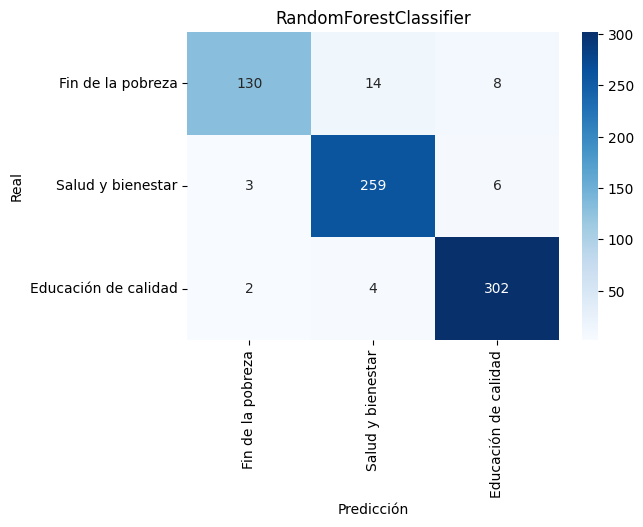

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'


In [134]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_leaf": [1, 5],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "RandomForestClassifier")

### 3.3.6 Linear SVC (Juan Hernández)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Mejor modelo: Pipeline(steps=[('clf',
                 LinearSVC(C=1, class_weight='balanced', random_state=42))])
 Mejores parámetros: {'clf__C': 1, 'clf__class_weight': 'balanced'}
 Mejor f1_macro en CV: 0.9811965069501385

 Evaluación en conjunto de test:
Accuracy:              0.9684
Precision (Macro):     0.9653
Precision (Weighted):  0.9684
Recall (Macro):        0.9618
Recall (Weighted):     0.9684
F1 (Macro):            0.9635
F1 (Weighted):         0.9683

 Reporte por clase:
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       152
           3       0.96      0.97      0.97       268
           4       0.98      0.98      0.98       308

    accuracy                           0.97       728
   macro avg       0.97      0.96      0.96       728
weighted avg       0.97      0.97      0.97       728



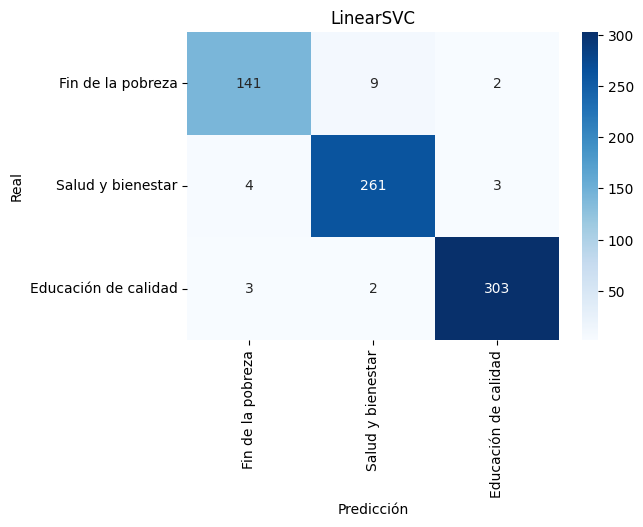

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1
,multi_class,'ovr'
,fit_intercept,True


In [135]:
model = LinearSVC(random_state=42)
param_grid = {
    "clf__C": [0.01, 0.1, 0.9, 1, 1.1, 10],
    "clf__class_weight": [None, "balanced"]
}
run_model(model, param_grid, "LinearSVC")

## 3.4 Seleccionar mejor modelo

In [136]:
# Diccionario de modelos y parámetros
param_grid = [

    # Multinomial Naive Bayes
    {
        "clf": [MultinomialNB()],
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    },

    # Logistic Regression
    {
        "clf": [LogisticRegression(max_iter=1000, random_state=42)],
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__class_weight": [None, "balanced"]
    },

    # Decision Tree
    {
        "clf": [DecisionTreeClassifier(random_state=42)],
        "clf__max_depth": [5, 10, 20, None],
        "clf__min_samples_leaf": [1, 5, 10],
        "clf__criterion": ["gini", "entropy"],
        "clf__class_weight": [None, "balanced"]
    },

    # KNN
    {
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": [1,2,3,4,3, 5, 10, 15],
        "clf__weights": ["uniform", "distance"]
    },

    # Random Forest
    {
        "clf": [RandomForestClassifier(random_state=42)],
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [10, 20, None],
        "clf__min_samples_leaf": [1, 5],
        "clf__class_weight": [None, "balanced"]
    },

    # SVM Lineal
    {
        "clf": [LinearSVC(random_state=42)],
        "clf__C": [0.01, 0.1, 0.9, 1, 1.1, 10],
        "clf__class_weight": [None, "balanced"]
    }
]


pipeline = Pipeline([
    ("clf", MultinomialNB())  # Placeholder
])

grid = GridSearchCV(
    pipeline,
    param_grid,
    # scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar sobre tus vectores ya listos
grid.fit(X_train_vec, y_train)

print("Mejor modelo:", grid.best_estimator_)
print("Mejores parámetros:", grid.best_params_)
print("Mejor f1_macro en CV:", grid.best_score_)

Fitting 5 folds for each of 113 candidates, totalling 565 fits
Mejor modelo: Pipeline(steps=[('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=42))])
Mejores parámetros: {'clf': LogisticRegression(max_iter=1000, random_state=42), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Mejor f1_macro en CV: 0.982903001908728


In [137]:
results = pd.DataFrame(grid.cv_results_)

# Ordenar por la métrica (mean_test_score)
top10 = results.sort_values(by="mean_test_score", ascending=False).head(10)

# Mostrar solo columnas relevantes
print("\nTop 10 modelos:")
top10[[
    "rank_test_score",
    "mean_test_score",
    "std_test_score",
    "params"
]]


Top 10 modelos:


,rank_test_score,mean_test_score,std_test_score,params
12,1,0.982903,0.004326,"{'clf': LogisticRegression(max_iter=1000, rand..."
108,1,0.982903,0.005713,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
110,1,0.982903,0.005713,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
106,4,0.982313,0.005270,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
10,5,0.980543,0.006878,"{'clf': LogisticRegression(max_iter=1000, rand..."
109,5,0.980543,0.003998,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
112,7,0.979953,0.002204,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
107,7,0.979953,0.005074,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
111,7,0.979953,0.002204,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."
105,10,0.979363,0.006188,"{'clf': LinearSVC(random_state=42), 'clf__C': ..."


In [143]:

def get_model_from_params(pipeline, params):
    """
    Clona el pipeline base y aplica los parámetros seleccionados.
    """
    model = clone(pipeline)
    model.set_params(**params)
    return model

In [150]:
def plot_top_words_from_model(trained_pipeline, vectorizer, title="", top_n=15):
    """
    Muestra las palabras más importantes de un modelo entrenado.
    Soporta LogisticRegression, LinearSVC y MultinomialNB.
    """
    best_model = trained_pipeline.named_steps["clf"]
    class_labels = trained_pipeline.named_steps["clf"].classes_
    
    # Caso modelos lineales
    if hasattr(best_model, "coef_"):
        feature_names = np.array(vectorizer.get_feature_names_out())
        coefs = best_model.coef_

        for i, class_label in enumerate(class_labels):
            top_indices = np.argsort(coefs[i])[-top_n:]
            top_features = feature_names[top_indices]
            top_weights = coefs[i][top_indices]

            plt.figure(figsize=(8, 6))
            plt.barh(top_features, top_weights, color="skyblue")
            plt.xlabel("Peso (coeficiente)")
            plt.title(f"{title} - Clase '{dict_ods[int(class_label)]}'")
            plt.gca().invert_yaxis()
            plt.show()

    else:
        print("NO")


Segundo mejor modelo con parámetros:
{'clf': LinearSVC(C=1, class_weight='balanced', random_state=42), 'clf__C': 1, 'clf__class_weight': 'balanced'}


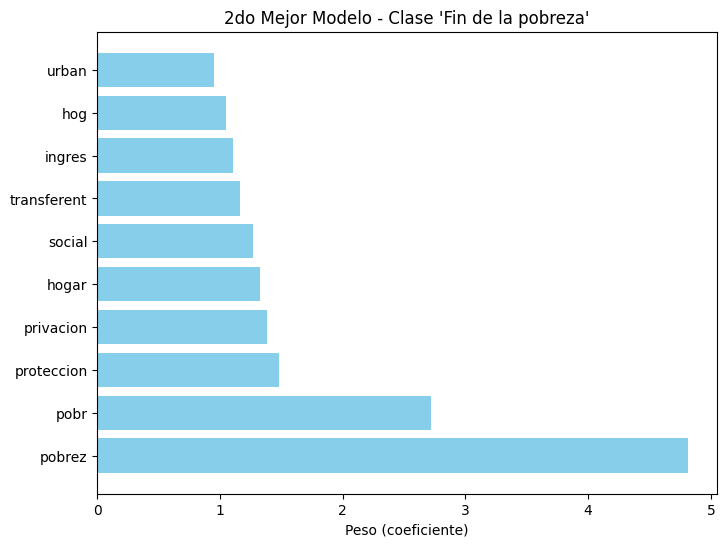

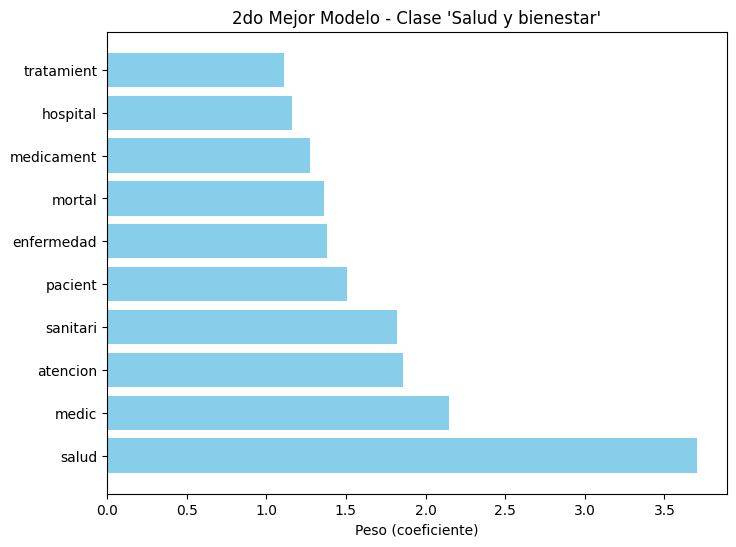

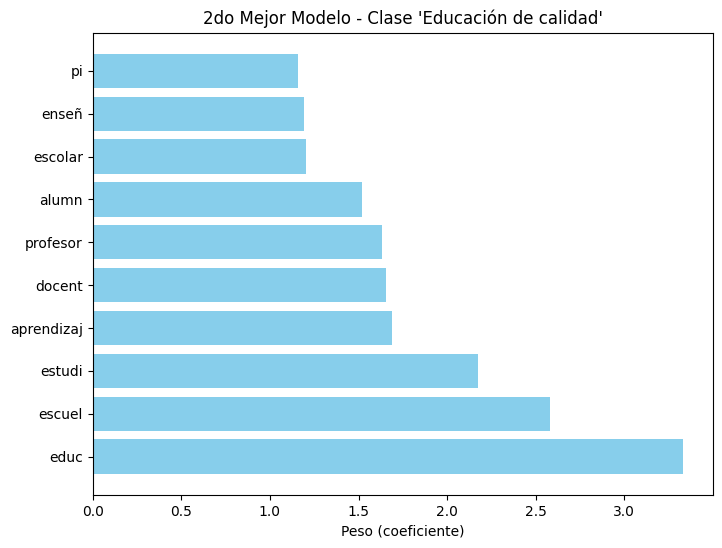

In [151]:
# Tomar los parámetros del segundo mejor modelo
second_best_params = top10.iloc[1]["params"]
print("Segundo mejor modelo con parámetros:")
print(second_best_params)

# Reconstruir y entrenar el modelo
second_model = get_model_from_params(pipeline, second_best_params)
second_model.fit(X_train_vec, y_train)

# Graficar top palabras
plot_top_words_from_model(second_model, vectorizer, title="2do Mejor Modelo", top_n=10)
